### Importing dependencies 

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fast')
import seaborn as sns
import missingno as msno
import category_encoders as ce
import pickle

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,PowerTransformer,MinMaxScaler
from sklearn.impute import KNNImputer
# from pycaret.classification import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Chossing a style ( can see the list using the code : plt.style.available
plt.style.use('default')
print("Everything imported successfully")

Everything imported successfully


### Loading the data from csv file

In [2]:
# Loading csv file
df = pd.read_csv('Data.csv')

# Introductory EDA

In [3]:
# Checking the shape of the dataframe
print('Shape of the dataframe :',df.shape)

Shape of the dataframe : (19158, 13)


In [4]:
# Checking any 5 random rows
df.sample(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target
12439,27985,city_103,0.920,NaN,Has relevent experience,no_enrollment,Graduate,STEM,20.0,10000+,Public Sector,12.0,0.0
6696,31227,city_21,0.624,Male,Has relevent experience,no_enrollment,Graduate,STEM,4.0,10000+,Pvt Ltd,298.0,1.0
13765,7728,city_165,0.903,NaN,Has relevent experience,no_enrollment,Masters,STEM,11.0,NaN,Pvt Ltd,49.0,0.0
3969,30792,city_46,0.762,Female,Has relevent experience,no_enrollment,Graduate,STEM,9.0,50-99,Pvt Ltd,20.0,0.0
3016,19664,city_10,0.895,Male,Has relevent experience,no_enrollment,Masters,STEM,20.0,10000+,Pvt Ltd,30.0,0.0


**Observation 🔍**

Out of all the features present in our dataset, enrollee_id and city are 2 features which will not be useful for predicting whether a person will get a data science job or not. So we will simply remove these features from the dataset

In [5]:
# Dropping unnecessary features
df.drop(['enrollee_id','city'],axis=1,inplace=True)

In [6]:
# Let's get some basic informatin about the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_development_index  18679 non-null  float64
 1   gender                  14650 non-null  object 
 2   relevent_experience     19158 non-null  object 
 3   enrolled_university     18772 non-null  object 
 4   education_level         18698 non-null  object 
 5   major_discipline        16345 non-null  object 
 6   experience              19093 non-null  float64
 7   company_size            13220 non-null  object 
 8   company_type            13018 non-null  object 
 9   training_hours          18392 non-null  float64
 10  target                  19158 non-null  float64
dtypes: float64(4), object(7)
memory usage: 1.6+ MB


**Observation 🔍**

- There are missing values present in our dataset.
- All features have correct base datatypes but they for storing the numerical data instead of using the float64 or int64 we can use the float32 and int32 to reduce the memory usage.

In [7]:
# Optimizing the memory by using appropriate data types
int_cols = df.select_dtypes(include=np.int64)
float_cols = df.select_dtypes(include=np.float64)

df[int_cols.columns] = df[int_cols.columns].astype(np.int32)
df[float_cols.columns] = df[float_cols.columns].astype(np.float32)

- Before memory usage : 1.6 mb
- After memory usage : 1.3 mb

In [8]:
# Descriptive information about the data
df.describe()

,city_development_index,experience,training_hours,target
count,18679.000000,19093.000000,18392.000000,19158.000000
mean,0.828951,9.928037,65.185791,0.249348
std,0.123334,6.505268,59.885624,0.432647
min,0.448000,0.000000,1.000000,0.000000
25%,0.740000,4.000000,23.000000,0.000000
50%,0.903000,9.000000,47.000000,0.000000
75%,0.920000,16.000000,88.000000,0.000000
max,0.949000,20.000000,336.000000,1.000000


**Observation 🔍**

- There are chances of presence of outliers in the city_development_index because there is sudden change in value from min to 25 perecentile.
- There are chances of presence of outliers in the training_hours because there is sudden change in values from 75 percentile to max.

In [9]:
# Checking percentage of null values
print(df.isnull().mean()*100)

# Checking number of duplicate values
print("Total duplicate values :",df.duplicated().sum())

city_development_index     2.500261
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
training_hours             3.998330
target                     0.000000
dtype: float64
Total duplicate values : 194


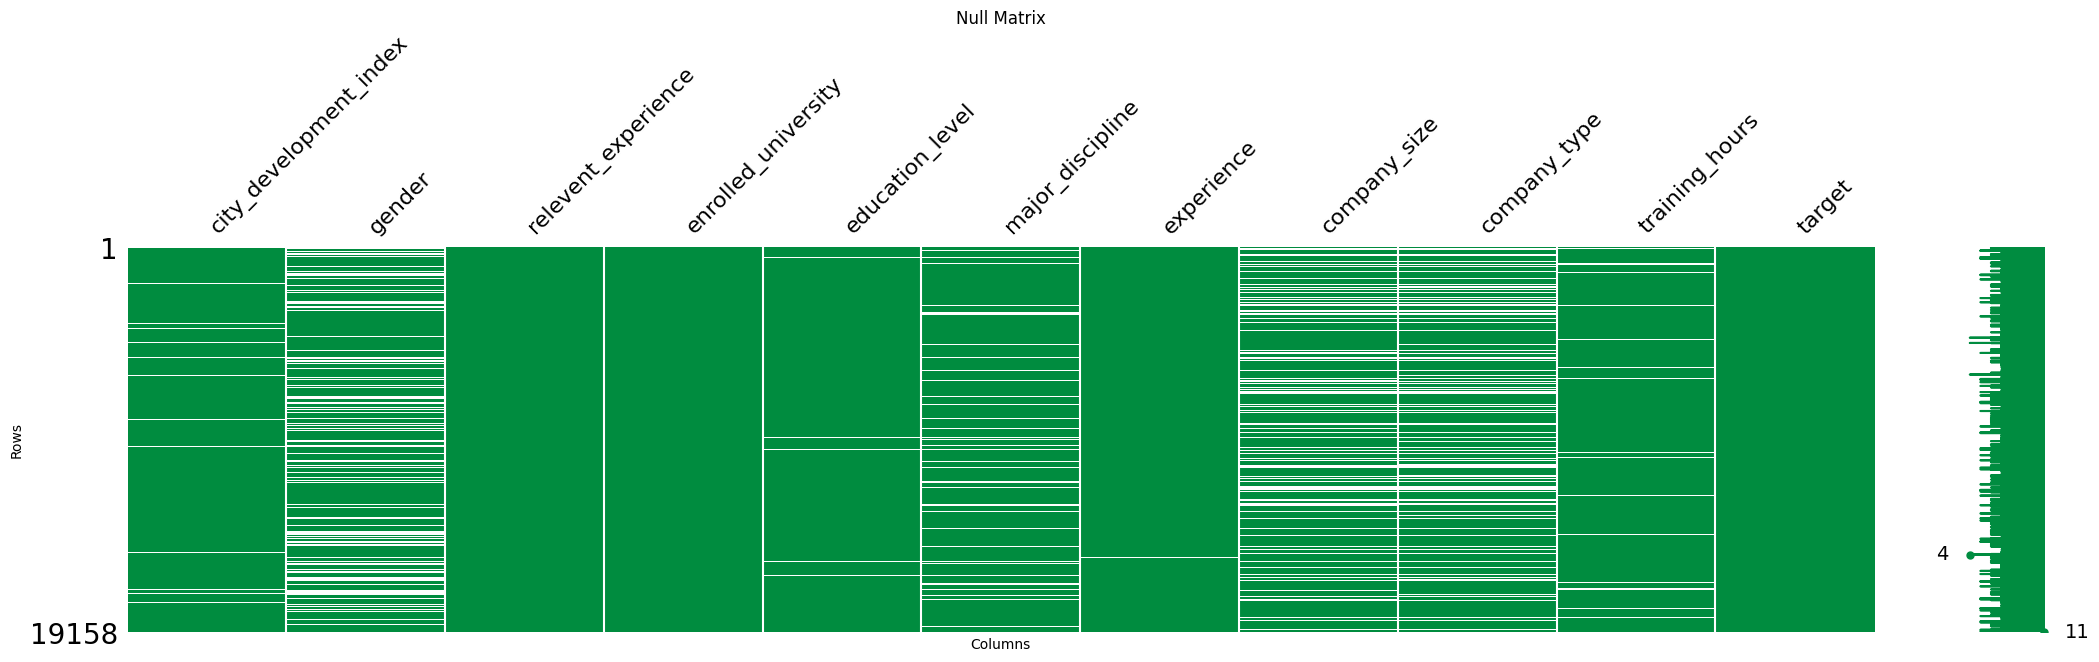

In [10]:
# Plot the null matrix to visualize if there are null values left
msno.matrix(df,figsize=(25, 5),color=(0, 0.55, 0.25))

# Set plot labels and title
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Null Matrix')

# Show the plot
plt.show()

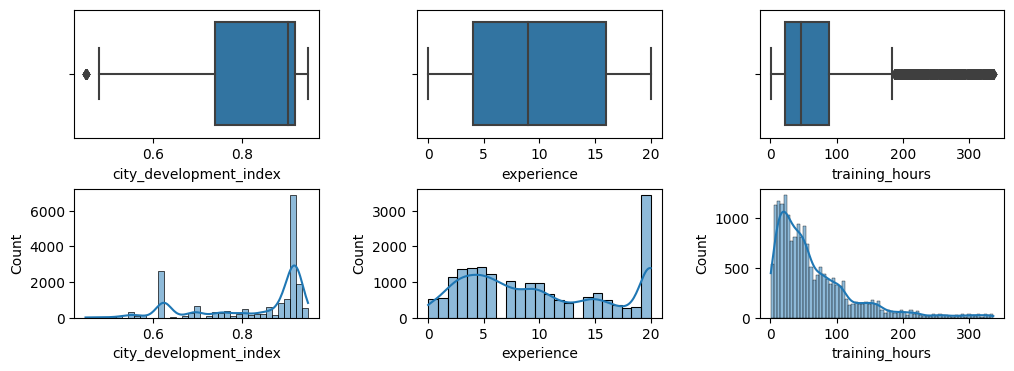

In [11]:
# Let's check if there are any outliers in the numerical columns
fig,ax = plt.subplots(2,3,figsize=(12,4))

sns.boxplot(x = df['city_development_index'],ax = ax[0][0])
sns.boxplot(x = df['experience'],ax = ax[0][1])
sns.boxplot(x = df['training_hours'],ax = ax[0][2])

sns.histplot(data = df['city_development_index'],ax = ax[1][0],kde=True)
sns.histplot(data = df['experience'],ax = ax[1][1],kde=True)
sns.histplot(data = df['training_hours'],ax = ax[1][2],kde=True)

plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.show()

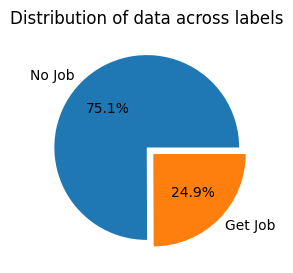

In [12]:
# Plot a pie chart 0 -> No job and 1 -> Get job
fig,ax = plt.subplots(figsize = (3,3))

ex = [0.0,0.1]
plt.pie(df['target'].value_counts(), labels=['No Job', 'Get Job'],autopct='%1.1f%%',explode = ex)
plt.title("Distribution of data across labels")
plt.show()

# Data Cleaning and processing

During the data cleaning and processing phase there are few steps which we need to perform with respect to this dataset and these steps are 👇

1. Handling missing values
2. Handling ouliters outliers
3. Encoding the categorical values
4. Scaling the numerical features

In [13]:
print("Before duplicate values:",df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("After duplicate values:",df.duplicated().sum())

Before duplicate values: 194
After duplicate values: 0


For the complete data processing we will be creating a pipeline, but before making a pipeling we need to explore all the techniques which we can use to process and clean our data in most efficient way and for this we will simply create a copy of the dataframe.

In [14]:
# Creating a copy of the dataframe
temp_df = df.copy()
temp_df.head(3)

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,20.0,NaN,NaN,36.0,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,47.0,0.0
2,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5.0,NaN,NaN,83.0,0.0


### Dealing with missing values

In order to deal with missing values we can either impute them or we can remove them. Generally for the features having percentage of missing values less than 5% it is safe to remove the missing values. But in order to retain as much data as possible we will compare the effect of both removing and imputing the missing values.

In [15]:
# Let's take out features having missing value percentage less than 5% 
Less_5PER = [col for col in temp_df.columns if temp_df[col].isnull().mean()*100 <5 and temp_df[col].isnull().mean()*100>0]

# Let's create 2 copy to compare the change in distribution
remove_nan = temp_df[Less_5PER].copy()
impute_nan = temp_df[Less_5PER].copy()

In [16]:
# Dropping all the rows having column values as NaN
remove_nan.dropna(inplace=True)

# Imputation
mean_impute_cols = ['city_development_index','experience','training_hours']
mode_impute_cols = ['enrolled_university','education_level']

for cols in mean_impute_cols:
    impute_nan[cols].fillna(impute_nan[cols].mean(),inplace=True)

for cols in mode_impute_cols:
    impute_nan[cols].fillna(impute_nan[cols].mode()[0],inplace=True)

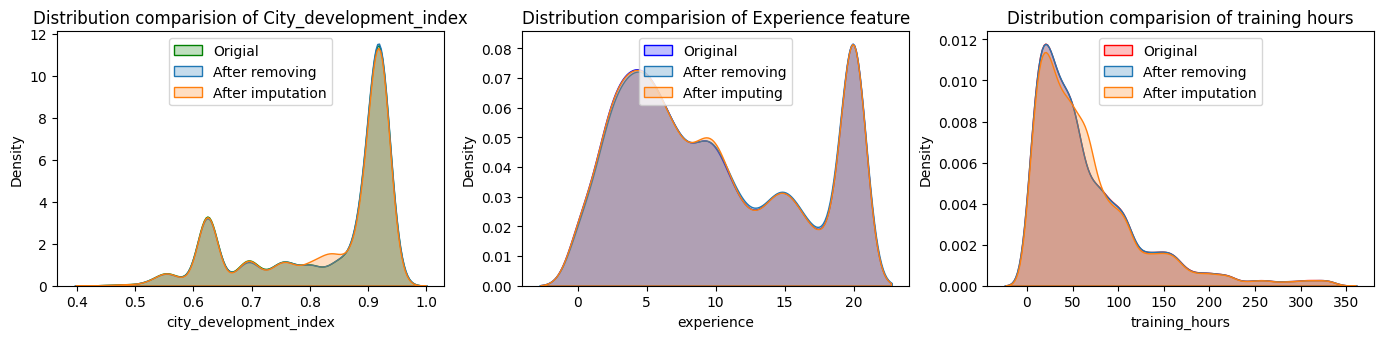

In [17]:
# Now let's visualize the distributions before and after implemnting CCA on numerical features
fig, ax = plt.subplots(1, 3, figsize=(17, 3.3))

sns.kdeplot(temp_df['city_development_index'], fill=True,ax=ax[0], color='green', label='Origial')
sns.kdeplot(remove_nan['city_development_index'], fill=True,ax=ax[0], label='After removing')
sns.kdeplot(impute_nan['city_development_index'], fill=True,ax=ax[0], label='After imputation')
ax[0].legend(loc='upper center')
ax[0].set(title='Distribution comparision of City_development_index')

sns.kdeplot(temp_df['experience'], fill=True,ax=ax[1], color='blue', label='Original')
sns.kdeplot(remove_nan['experience'], fill=True,ax=ax[1], label='After removing')
sns.kdeplot(impute_nan['experience'], fill=True,ax=ax[1], label='After imputing')
ax[1].legend(loc='upper center')
ax[1].set(title='Distribution comparision of Experience feature')

sns.kdeplot(temp_df['training_hours'], fill=True,ax=ax[2], color='red', label='Original')
sns.kdeplot(remove_nan['training_hours'], fill=True,ax=ax[2], label='After removing')
sns.kdeplot(impute_nan['training_hours'], fill=True,ax=ax[2], label='After imputation')
ax[2].legend(loc='upper center')
ax[2].set(title='Distribution comparision of training hours')

plt.show()

For the categorical columns we will check the ratio of categories before and after applying CCA

In [18]:
# For the categorical features we will check the ratio of classes before and after implementing CCA
compare_eu = pd.concat([temp_df['enrolled_university'].value_counts() / len(temp_df),
                    remove_nan['enrolled_university'].value_counts() / len(remove_nan),
                    impute_nan['enrolled_university'].value_counts()/len(impute_nan)],axis=1)

compare_eu.columns = ['Original','After removing','After imputation']
compare_eu

,Original,After removing,After imputation
no_enrollment,0.718888,0.732981,0.739243
Full time course,0.197585,0.202293,0.197585
Part time course,0.063172,0.064727,0.063172


In [19]:
compare_edu_level = pd.concat([ temp_df['education_level'].value_counts() / len(temp_df),
                        remove_nan['education_level'].value_counts() / len(remove_nan),
                        impute_nan['education_level'].value_counts()/len(impute_nan)],axis=1)

compare_edu_level.columns = ['Original','After removing','After imputation']
compare_edu_level

,Original,After removing,After imputation
Graduate,0.602668,0.617284,0.626872
Masters,0.229066,0.235567,0.229066
High School,0.105990,0.108054,0.105990
Phd,0.021831,0.022340,0.021831
Primary School,0.016241,0.016755,0.016241


From our analysis we can clearly see that for all the columns having percentage of missing values less than 5% the distribution is not changing a lot after imputation in the numerical features and for the categorical features as well the ratio is not changing a lot after imputation, thus to keep as much data as we can we will imputing the missing values instead of removing them.

In [20]:
mean_impute_cols = ['city_development_index','experience','training_hours']
mode_impute_cols = ['enrolled_university','education_level']

for cols in mean_impute_cols:
    temp_df[cols].fillna(temp_df[cols].mean(),inplace=True)

for cols in mode_impute_cols:
    temp_df[cols].fillna(temp_df[cols].mode()[0],inplace=True)

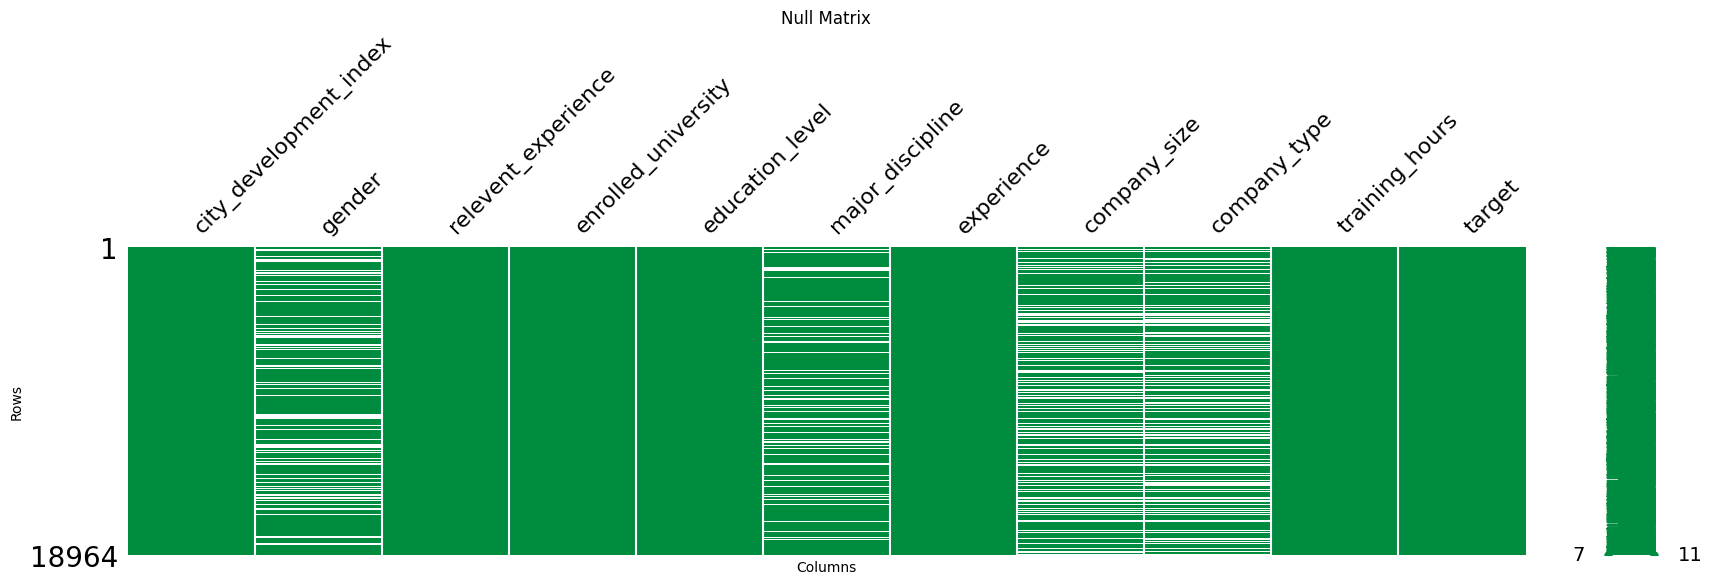

In [21]:
# Plot the null matrix to visualize if there are null values left
msno.matrix(temp_df,figsize=(20, 4),color=(0, 0.55, 0.25))

# Set plot labels and title
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Null Matrix')

# Show the plot
plt.show()

For other columns like Gender, major discipline, company size and company type we will be using advance imputation technique like KNN imputer, but for using any advance imputation techniue we need to make sure our data is ready which means our data should be properly encoded for KNN  imputer and should also be free from the outliers, so before using the KNN imputer we will encode and deal with outliers and then we will use KNN imputer for imputing the missing values. 

### Dealing with outliers

Let's now deal with the outliers. From the previous analysis we got to know that city_development_index and training_hours both had outliers and both of these features had a skewness in thier distribution. So in order to deal with the missing values we can use IQR method and in this method we can either cap them our remove them.

Apart from this one more popular and good for dealing with misisng values is to transform the data using some mathematical transformations.

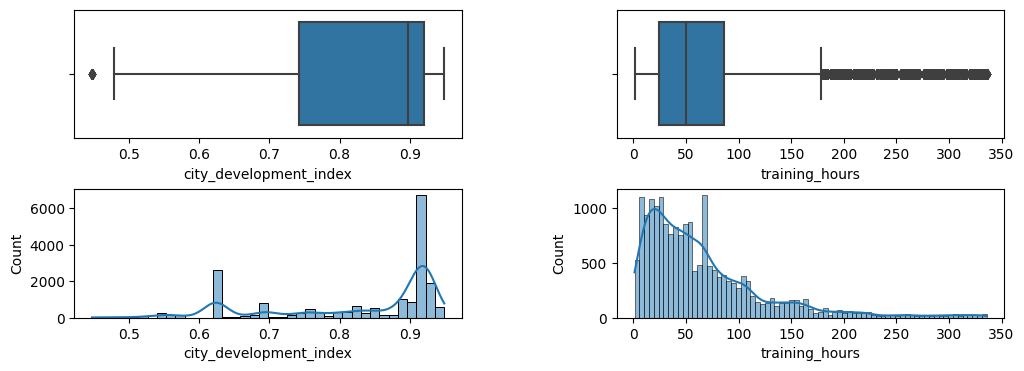

In [22]:
# Let's check if there are any outliers in the numerical columns
fig,ax = plt.subplots(2,2,figsize=(12,4))

sns.boxplot(x = temp_df['city_development_index'],ax = ax[0][0])
sns.boxplot(x = temp_df['training_hours'],ax = ax[0][1])

sns.histplot(data = temp_df['city_development_index'],ax = ax[1][0],kde=True)
sns.histplot(data = temp_df['training_hours'],ax = ax[1][1],kde=True)

plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.show()

In [23]:
# Transforming the data using Yeo-Johnson transformation
pt = PowerTransformer()

temp_df[['city_development_index','training_hours']] = pt.fit_transform(temp_df[['city_development_index','training_hours']])

C:\Users\ys723\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\ys723\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


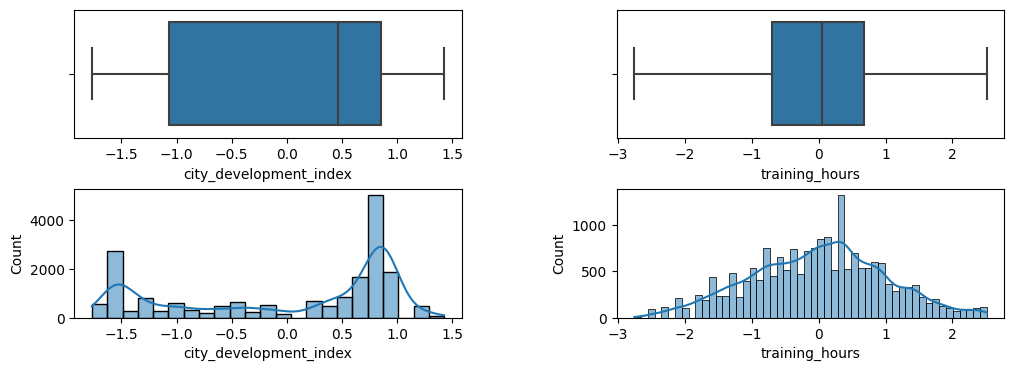

In [24]:
# Let's check if there are any outliers in the numerical columns after transformation
fig,ax = plt.subplots(2,2,figsize=(12,4))

sns.boxplot(x = temp_df['city_development_index'],ax = ax[0][0])
sns.boxplot(x = temp_df['training_hours'],ax = ax[0][1])

sns.histplot(data = temp_df['city_development_index'],ax = ax[1][0],kde=True)
sns.histplot(data = temp_df['training_hours'],ax = ax[1][1],kde=True)

plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.show()

### Dealing with categorical columns

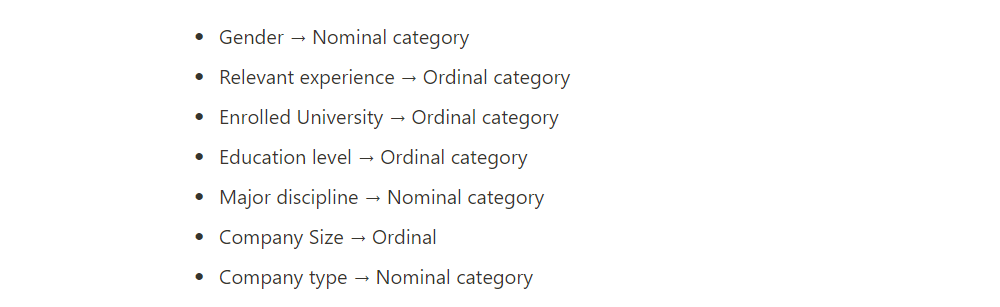

🚨 An important thing we must keep in mind is that for dealing with the nominal categorical values we can either use one hot encoding or target encoding. But the use of any of the technique is totally based on the cardinality of the column.

- If there is high cardinality ➡️ Target encoding
- If there is less cardinality ➡️ One hot encoding

In [26]:
# Resetting the index
temp_df.reset_index(inplace=True,drop=True)

In [27]:
# Intializing ordinal encoder class
oe_re = OrdinalEncoder(categories=[['No relevent experience', 'Has relevent experience']],handle_unknown='use_encoded_value', unknown_value=np.nan)
oe_eu = OrdinalEncoder(categories=[['no_enrollment', 'Part time course', 'Full time course']],handle_unknown='use_encoded_value', unknown_value=np.nan)
oe_el = OrdinalEncoder(categories=[['Primary School', 'High School', 'Graduate', 'Masters', 'Phd']],handle_unknown='use_encoded_value', unknown_value=np.nan)
oe_cs = OrdinalEncoder(categories=[['<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']],handle_unknown='use_encoded_value', unknown_value=np.nan)

# Intializing the target encoder class
te_md = ce.TargetEncoder(smoothing=0.2, handle_missing='return_nan',return_df=False)
te_ct = ce.TargetEncoder(smoothing=0.2, handle_missing='return_nan',return_df=False)
te_gen = ce.TargetEncoder(smoothing=0.2, handle_missing='return_nan',return_df=False)


temp_df['relevent_experience'] = pd.Series(oe_re.fit_transform(temp_df['relevent_experience'].values.reshape(-1,1)).reshape(-1))
temp_df['enrolled_university'] = pd.Series(oe_eu.fit_transform(temp_df['enrolled_university'].values.reshape(-1,1)).reshape(-1))
temp_df['education_level'] = pd.Series(oe_el.fit_transform(temp_df['education_level'].values.reshape(-1,1)).reshape(-1))
temp_df['company_size'] = pd.Series(oe_cs.fit_transform(temp_df['company_size'].values.reshape(-1,1)).reshape(-1))


y = temp_df['target'].values.reshape(-1,1)
temp_df['major_discipline'] = pd.Series(te_md.fit_transform(temp_df['major_discipline'].values.reshape(-1,1),y).reshape(-1))
temp_df['company_type'] = pd.Series(te_ct.fit_transform(temp_df['company_type'].values.reshape(-1,1),y).reshape(-1))
temp_df['gender'] = pd.Series(te_gen.fit_transform(temp_df['gender'].values.reshape(-1,1),y).reshape(-1))

Now since we handled the missing values and have encoded the categorical values so let's simply use KNN imputer for imputing missing values in the columns where percentage of missing values is more than 5%.

In [30]:
knn_imputer = KNNImputer(n_neighbors=5, metric='nan_euclidean')

cols = ['gender','major_discipline','company_size','company_type']
temp_df[cols] = knn_imputer.fit_transform(temp_df[cols])

### Feature selection/Extraction

<Axes: >

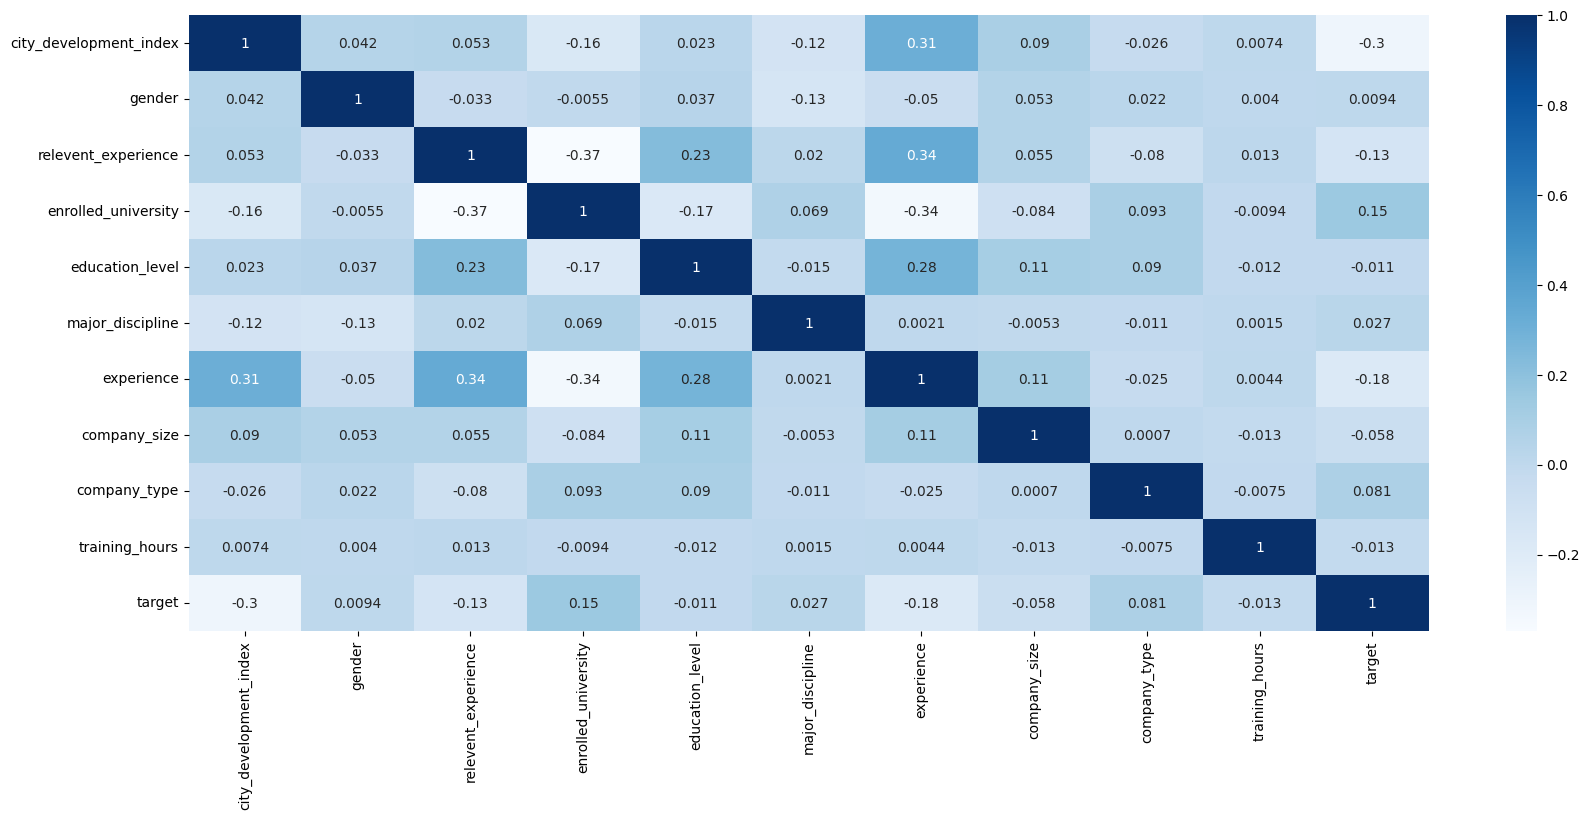

In [36]:
fig,ax = plt.subplots(figsize = (20,8))
sns.heatmap(temp_df.corr(),annot=True,cmap = "Blues")

# Creation of Pipeline

As we have explored all the techniques which we will be using to deal with misssing values, outliers and cateogircal features. We will now create a pipeline that will do all the data cleaning and processing in a streamlined process.

- First we will create a column transformer to deal with missing values ( Simple imputtation techniques )
- Then we will create a column transformer for doing ordinal and target encoding
- After doing encoding we will use KNN imputer to impute the columns which were having high missing values percentage
- Followed by this we will scale our values
- Finally we will be using a machine learning model for training

**Down below is the descirption all the change in column positions after the data will go through each and every column transformer**

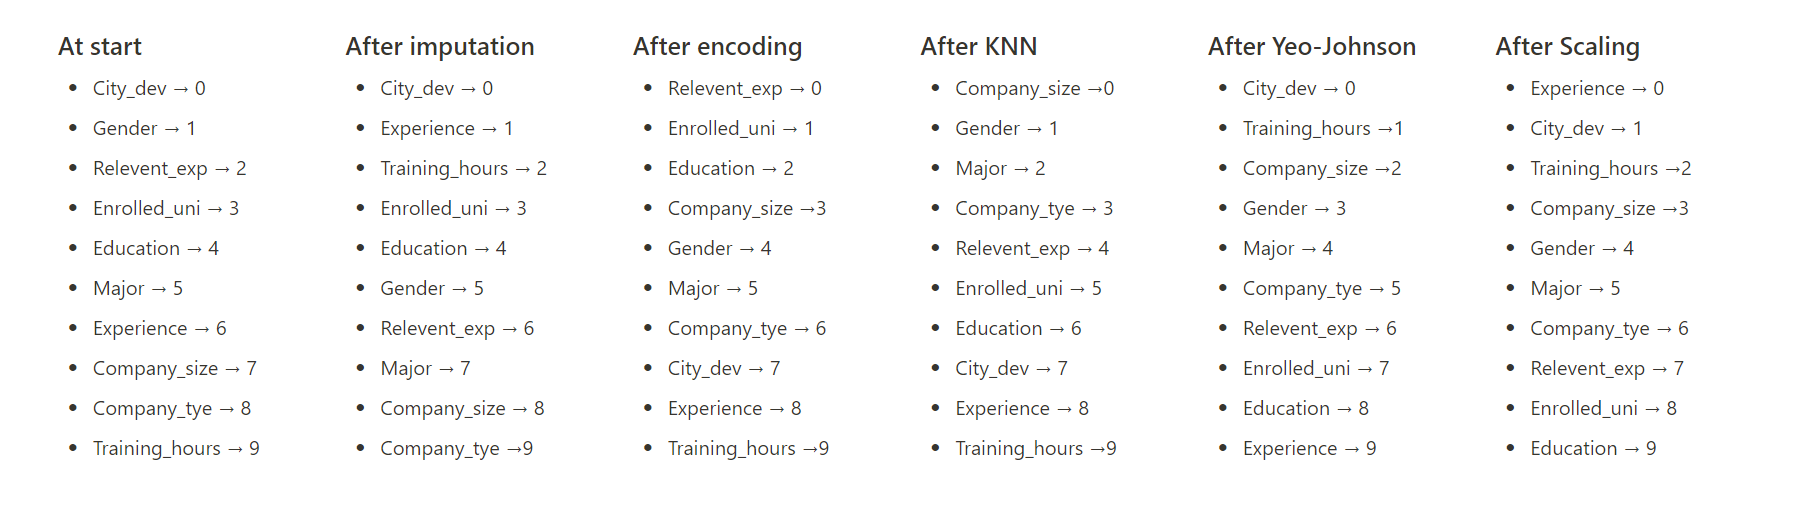

In [49]:
# Define the column transformer for imputation
Simple_impute_transformer = ColumnTransformer(transformers=[
    ('mean_imputer', SimpleImputer(strategy='mean'), [0, 6, 9]),
    ('mode_imputer', SimpleImputer(strategy='most_frequent'), [3, 4])        
], remainder='passthrough')

# Define the column transformer for encoding
encode_values = ColumnTransformer(transformers=[
    ('Encode_ordinal_Re', OrdinalEncoder(categories=[['No relevent experience', 'Has relevent experience']],handle_unknown='use_encoded_value', unknown_value=np.nan), [6]),
    ('Encode_ordinal_eu', OrdinalEncoder(categories=[['no_enrollment', 'Part time course', 'Full time course']],handle_unknown='use_encoded_value', unknown_value=np.nan), [3]),
    ('Encode_ordinal_el', OrdinalEncoder(categories=[['Primary School', 'High School', 'Graduate', 'Masters', 'Phd']],handle_unknown='use_encoded_value', unknown_value=np.nan), [4]),
    ('Encode_ordinal_cs', OrdinalEncoder(categories=[['<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']],handle_unknown='use_encoded_value', unknown_value=np.nan), [8]),
    ('Encode_target_gen', ce.TargetEncoder(smoothing=0.2, handle_missing='return_nan'), [5]),
    ('Encode_target_major', ce.TargetEncoder(smoothing=0.2, handle_missing='return_nan'), [7]),
    ('Encode_target_ct', ce.TargetEncoder(smoothing=0.2, handle_missing='return_nan'), [9])
], remainder='passthrough')

Knn_imputer = ColumnTransformer(transformers=[
    ('Knn_Imputer', KNNImputer(n_neighbors=5, metric='nan_euclidean'), [3,4, 5, 6])
], remainder='passthrough')

yeo_transformation = ColumnTransformer(transformers = [
    ('Yeo-Johnson',PowerTransformer(),[0,9])
],remainder = 'passthrough')

# Column transformer to do feature scaling
scaling_transformer = ColumnTransformer(transformers=[
    ('scale_transformer', MinMaxScaler(), [9])
], remainder='passthrough')

Algorithm = RandomForestClassifier(n_estimators=100)

# Define the final pipeline
pipe = Pipeline(steps=[
    ('impute_transformer', Simple_impute_transformer),
    ('encode_values', encode_values),
    ('Knn_imputer', Knn_imputer),
    ('Yeo-Johnson-Transformation', yeo_transformation),
    ('Scaling', scaling_transformer),
    ('ML_Model', Algorithm)
])

In [41]:
# Seperating the data into dependent and independnet variable
X = df.drop(['target'],axis=1)
y = df['target']

# Let's split the data into train,test and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

### Model training and evaluation

- For using pipeline for cleaning and transforming pipe.fit_transform(X_train,y_train)

In [50]:
# Training the model
pipe.fit(X_train,y_train)

# Let's get predicted labels
y_pred = pipe.predict(X_test)

## Model evlauation

In [27]:
# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

# Calculating precision
precision = precision_score(y_test, y_pred, average='macro')
print("Precision: ", precision)

# Calculating recall
recall = recall_score(y_test, y_pred, average='macro')
print("Recall: ", recall)

# Calculating F1 score
f1 = f1_score(y_test, y_pred, average='macro')
print("F1 Score: ", f1)

Accuracy:  0.8710470836261419
Precision:  0.8742822244618302
Recall:  0.8712109314811961
F1 Score:  0.8708018217937394


In [28]:
# Saving model and pickle file
pickle.dump(df,open('df.pkl','wb'))
pickle.dump(pipe,open('pipe.pkl','wb'))

### Comparing multiple models

In [44]:
# Get the list of available models
all_models = models()

# Print the list of models
models().index.values

array(['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge',
       'rf', 'qda', 'ada', 'gbc', 'lda', 'et', 'lightgbm', 'dummy'],
      dtype=object)

In [47]:
# initialize setup with preprocessing
clf = setup(data, target=y_train,preprocess= False,use_gpu=True)

# compare selected models
best_model = compare_models(include= ['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge',
       'rf', 'qda', 'ada', 'gbc', 'lda', 'et', 'lightgbm', 'dummy'])

,Description,Value
0,Session id,5513
1,Target,target
2,Target type,Binary
3,Original data shape,"(17076, 11)"
4,Transformed data shape,"(17076, 11)"
5,Transformed train set shape,"(11953, 11)"
6,Transformed test set shape,"(5123, 11)"
7,Categorical features,10


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8375,0.8992,0.8715,0.8163,0.8429,0.6751,0.6767,2.2080
et,Extra Trees Classifier,0.8269,0.9074,0.8485,0.8136,0.8306,0.6538,0.6545,1.7160
lightgbm,Light Gradient Boosting Machine,0.8012,0.8529,0.8133,0.7944,0.8036,0.6024,0.6028,3.5810
dt,Decision Tree Classifier,0.7775,0.7795,0.8404,0.7466,0.7907,0.5549,0.5595,0.4610
gbc,Gradient Boosting Classifier,0.7560,0.7993,0.7339,0.7681,0.7506,0.5121,0.5127,2.0740
ada,Ada Boost Classifier,0.7477,0.7889,0.7020,0.7729,0.7356,0.4954,0.4976,1.2750
knn,K Neighbors Classifier,0.7210,0.7746,0.7605,0.7051,0.7317,0.4420,0.4435,1.1220
gpc,Gaussian Process Classifier,0.7139,0.7660,0.7086,0.7167,0.7125,0.4278,0.4279,197.0630
mlp,MLP Classifier,0.7112,0.7681,0.7026,0.7169,0.7087,0.4224,0.4236,15.8810
rbfsvm,SVM - Radial Kernel,0.6935,0.7451,0.6717,0.7028,0.6867,0.3871,0.3876,44.5920


Since we can clearly see that random forest classifier is performing the best so we will use this algorithm.